# 概要

ここではVision transformerを使った骨のレントゲン画像の分類を行う。

使用するデータセットは[MURA](https://stanfordmlgroup.github.io/competitions/mura/)で、
今回は手の画像からpositive or negativeを判別できないか試す。

必要なライブラリをpipでインストールしておくと良い。

In [1]:
!pip install vit_pytorch timm

## 先述のデータセットから構成をVit用に配置し直したものをダウンロードする。

ダウンロードはこちらから

- [trainデータ](https://drive.google.com/drive/folders/1_foeLxsl1Nm_PuoZZbjvrfvtFVPAW_8Y?usp=drive_link)

- [valデータ](https://drive.google.com/drive/folders/1PQLm2vNkGP9ABKjGqBMZfy_hMcPYugiM?usp=drive_link)

## データセットを自身のドライブにアップロードする

ドライブにアップロードした後はColab上でGoogleドライブをマウントする

# ライブラリのインストール

In [2]:
from __future__ import print_function

import glob
import os
import random
import cv2
# Google Colab環境下ならcv2の代わりにこれを使用する
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT
from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint

# 学習条件、ランダムシードの設定

In [3]:
# Training settings
epochs = 30
lr = 0.01
gamma = 0.7
seed = 42

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [5]:
# GPUの設定
device = 'cuda'

# 学習データセットの設定

ドライブにアップしたtrainデータとvalデータのパスをコピーする

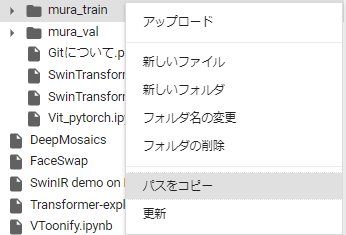

In [6]:
# コピーしたパスを貼り付ける
train_dataset_dir = Path('/content/drive/MyDrive/Colab Notebooks/花岡さん/mura_train')
val_dataset_dir = Path('/content/drive/MyDrive/Colab Notebooks/花岡さん/mura_val')

上手く読み込めているか確認

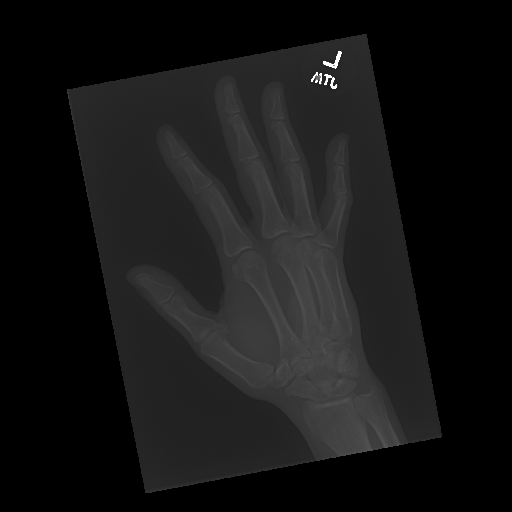

In [7]:
# 必要に応じてパスを変更する
img_file = '/content/drive/MyDrive/Colab Notebooks/花岡さん/mura_train/negative/patient00050_image1.png'
img = cv2.imread(img_file)
cv2_imshow(img)

# データセットの前処理

In [8]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

# データセットのロード

In [9]:
train_data = datasets.ImageFolder(train_dataset_dir,train_transforms)
valid_data = datasets.ImageFolder(val_dataset_dir, val_transforms)

データをバッチに分ける。

今回バッチサイズは16にするが、メモリが足らない場合は数字をあげる。

In [10]:
train_loader = DataLoader(dataset = train_data, batch_size=64, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=64, shuffle=True)

# Vitモデルのロード


In [11]:
model_names = timm.list_models(pretrained=False)
# ファインチューニングしたい場合はpretrained=True
# model_names = timm.list_models(pretrained=True)
pprint(model_names)

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

今回は'vit_base_patch16_224_in21k'を選んでみる

In [12]:
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=False, num_classes=2)
# ファインチューニングしたい場合はpretrained=True
# model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=2)

# modelをGPUで動作させる
# Google Colabでランタイプ：GPUにしている場合は必要
model.to("cuda:0")

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

# Vit学習

損失関数、活性化関数の設定をする。

今回はクロスエントロピーロス、アダムを使う。

In [13]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

学習ループを設定し、実行していく

In [14]:
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    train_acc_list.append(epoch_accuracy)
    val_acc_list.append(epoch_val_accuracy)
    train_loss_list.append(epoch_loss)
    val_loss_list.append(epoch_val_loss)

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.9251 - acc: 0.6355 - val_loss : 0.8425 - val_acc: 0.5679



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6424 - acc: 0.6859 - val_loss : 1.2525 - val_acc: 0.5675



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6327 - acc: 0.6944 - val_loss : 0.7829 - val_acc: 0.5661



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6452 - acc: 0.6869 - val_loss : 1.0794 - val_acc: 0.5689



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6172 - acc: 0.6974 - val_loss : 0.7751 - val_acc: 0.5652



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6536 - acc: 0.6836 - val_loss : 0.8212 - val_acc: 0.5689



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.5976 - acc: 0.7244 - val_loss : 0.6906 - val_acc: 0.5661



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.5957 - acc: 0.7239 - val_loss : 0.7975 - val_acc: 0.5656



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.5896 - acc: 0.7254 - val_loss : 0.7665 - val_acc: 0.5665



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.5882 - acc: 0.7256 - val_loss : 0.7722 - val_acc: 0.5670



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.5895 - acc: 0.7239 - val_loss : 0.7143 - val_acc: 0.5675



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.5883 - acc: 0.7249 - val_loss : 0.7771 - val_acc: 0.5698



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.5873 - acc: 0.7242 - val_loss : 0.7466 - val_acc: 0.5675



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.5850 - acc: 0.7251 - val_loss : 0.7270 - val_acc: 0.5661



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.5863 - acc: 0.7249 - val_loss : 0.7530 - val_acc: 0.5670



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.5844 - acc: 0.7256 - val_loss : 0.7465 - val_acc: 0.5675



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.5855 - acc: 0.7249 - val_loss : 0.7544 - val_acc: 0.5670



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.5861 - acc: 0.7254 - val_loss : 0.7042 - val_acc: 0.5698



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.5838 - acc: 0.7254 - val_loss : 0.7778 - val_acc: 0.5656



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.5895 - acc: 0.7254 - val_loss : 0.7323 - val_acc: 0.5698



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.5867 - acc: 0.7242 - val_loss : 0.7910 - val_acc: 0.5656



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.5883 - acc: 0.7244 - val_loss : 0.6962 - val_acc: 0.5698



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.5906 - acc: 0.7251 - val_loss : 0.7132 - val_acc: 0.5698



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.5853 - acc: 0.7244 - val_loss : 0.6944 - val_acc: 0.5656



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.5892 - acc: 0.7251 - val_loss : 0.7218 - val_acc: 0.5675



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.5906 - acc: 0.7251 - val_loss : 0.7321 - val_acc: 0.5716



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.5861 - acc: 0.7235 - val_loss : 0.7411 - val_acc: 0.5638



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.5859 - acc: 0.7251 - val_loss : 0.7554 - val_acc: 0.5689



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.5845 - acc: 0.7254 - val_loss : 0.7533 - val_acc: 0.5633



  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.5830 - acc: 0.7246 - val_loss : 0.7103 - val_acc: 0.5656



# 学習結果の可視化

<ipython-input-17-3abbb06b7a7d>:37: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1,2,1)


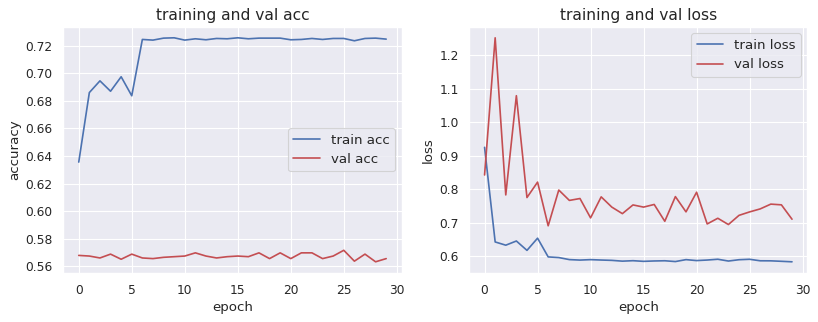

In [17]:
#出力したテンソルのデバイスをCPUへ切り替える
# GoogleColabの場合は不要
device2 = torch.device('cpu')

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for i in range(epochs):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)

    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)

    val_acc2 = val_acc_list[i].to(device2)
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)

    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = epochs

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()

# 結果と考察

## 結果

- val acc：0.56程度なので精度としては微妙
- train acc:072程度なので過学習というよりは局所最適解の可能性
- 最低でもval acc:0.7程度無いと希望が持てないレベル

## 考察

- 局所最適解かどうか確かめるためにバッチサイズを下げ、１エポックあたりの学習枚数を増やす（大きなメモリが必要）
- データセットがいろんな手の形をしているのでどこを特徴とすればいいのか分からない。→パーの形のみの学習データセットにしてみる
- 他のモデルも検討してみる。（大きな改善は見込めない）